## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        c0 = fd.exp(x*y*self.t)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        bcc1 = [fd.DirichletBC(self.V['cd'].sub(0), c0, 'on_boundary')]

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]
        self.bc['cd'][0] = [bcc1, c0, 'on_boundary', 0, 'update']

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }

# MMS Code Verification

## Spatial discretization

time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000
time = 1.000
time = 2.000


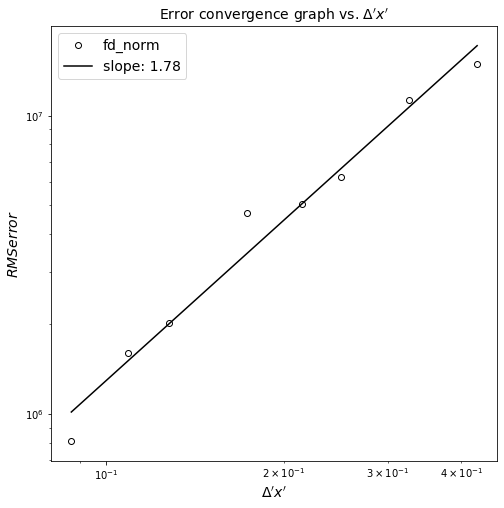

In [6]:
import sympy as sy

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.001,
'T': 2.0
}
)
mesh = fd.Mesh("../../meshes/step1.msh")
# add subsystems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
#setup system and define subsystems
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['cd', 'cs', 'as'], 'cdcsas', radio_transport_mms)
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
meshes = [fd.Mesh("../../meshes/step%d.msh" % i) for i in range(1, 9)]
solver.test_mms('cd', expr, spatial=True, f_dict={"exp":fd.exp}, meshes=meshes, plot=True, index=0)


## Temporal discretization

In [39]:
import sympy as sy

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.01,
'T': 0.1}
)

mesh = fd.Mesh("../../meshes/step1.msh")

deltat = [0.01 / (2**i) for i in range(8)]

# create solver and add systems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
#setup system and define subsystems
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
solver.test_mms('cd', expr, temporal=True, f_dict={"exp":fd.exp}, dt_list=deltat, plot=True, index=0)

0.01
0.005
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05
